In [1]:
import numpy as np

import scipy.io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

np.set_printoptions(precision=2,
                       threshold=100000,
                       linewidth=100,suppress='True')

# Enable matplotlib inline plotting in ipython notebook
%matplotlib inline

# Enable autoreload of external modules
%load_ext autoreload
%autoreload 2

# Load in the data
mat = scipy.io.loadmat('Mouse_Brain2013.mat')

# Number of rows
y_size = np.int32(mat['y_size'][0][0])
# Number of columns
x_size = np.int32(mat['x_size'][0][0])
# Number of total pixels
nb_pixels = y_size * x_size
# Number of bins
feat_size = len(mat['mz_values'][0])

# mapping from pixel index to row-col
row2grid = mat.get('row2grid')
# Baseline normalised non-zero pixels
ims_bn = mat.get('ims_bn')
data=np.transpose(ims_bn)
# Number of nonzero pixels
nb_nonzero_pix = ims_bn.shape[1]
# List of booleans telling if the pixel is zero or not
nonnull_spots  = mat['nonnull_spots']





def get_img(data, bin_nb):
    """
    Generate an image from a specific mz bin in the MSI dataset.
    The data rows have to correspond to pixels.
    The data columns have to correspond to mz bins.
    """
    img = np.ndarray(shape=(y_size, x_size), dtype=float)
    nonzero_pix_idx = 0
    for pix_idx in xrange(nb_pixels):
        y, x = row2grid[pix_idx] - 1
        if nonnull_spots[pix_idx]:
            img[x,y] = data[nonzero_pix_idx, bin_nb]
            nonzero_pix_idx += 1
        else:
            img[x,y] = 0.0
    return img

def get_label_img(data):
       
    img = np.ndarray(shape=(y_size, x_size), dtype=float)
    nonzero_pix_idx = 0
    for pix_idx in xrange(nb_pixels):
        y, x = row2grid[pix_idx] - 1
        if nonnull_spots[pix_idx]:
            img[x,y] = data[nonzero_pix_idx]
            nonzero_pix_idx += 1
        else:
            img[x,y] = 0.0
    return img

def get_ruis(label):
    img = np.ndarray(shape=(y_size, x_size), dtype=float)
    nonzero_pix_idx = 0
    for pix_idx in xrange(nb_pixels):
        y, x = row2grid[pix_idx] - 1
        if nonnull_spots[pix_idx]:
            img[x,y] = label[nonzero_pix_idx]
            nonzero_pix_idx += 1
        else:
            img[x,y] = 0.0
    
    
    
    
    temp=0.0
    for xindex in range(2,img.shape[0]-2):
        for yindex in range(2,img.shape[1]-2):
            temp_pix=0.0
            for x in range(-2, 3):
                for y in range(-2,3):
                    if img[xindex,yindex] == img[xindex+x,yindex+y]:
                        temp_pix=temp_pix+1
                    else:
                        temp_pix=temp_pix+0
            temp=temp + temp_pix/25
            
    
    ruis=temp/(1568.0)
                
    return ruis

def get_pca_vgl(label):
    
    pca_label=np.loadtxt('PCA-kmean-label.txt')
    jaccard_matrix=np.zeros([7,7])
    
    pca_set = [set() for _ in xrange(7)]

    for j in range (pca_label.size):
        ind= np.int_(pca_label[j])
        pca_set[ind].add(j)
        
        
        
    label_set = [set() for _ in xrange(7)]

    for j in range (label.size):
        ind= np.int_(label[j])
        label_set[ind].add(j)
        
    
    for k in range(7):
        for l in range(7):
            jaccard_matrix[k,l]=len(pca_set[k].intersection(label_set[l])) / float(len(pca_set[k].union(label_set[l])))
    
    value=np.zeros(8)
    mapping=[set() for _ in xrange(8)]
    pre_jaccard_matrix=jaccard_matrix
    for step in range(7,0,-1):
        indices= np.unravel_index(np.argmax(jaccard_matrix),[step,step])
        value[step]=jaccard_matrix[indices]
        mapping[step]=indices
        jaccard_matrix=np.delete(jaccard_matrix, indices[0], 0)
        jaccard_matrix=np.delete(jaccard_matrix, indices[1], 1)
    
    jaccard_index=np.sum(value)
    value=np.delete(value,0)
    
    return jaccard_index, pre_jaccard_matrix, value

data= data/np.max(data)

data= data.astype(np.float32)

In [ ]:
import os
import sys
import time

import numpy

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams



wfactors=[1,1,1,1]
regws=[0.01,0.001,0,0]
regbs=[0.01,0.001,0,0]
pretrain_epochs=1000



class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, wfactor, W=None, b=None,
                 activation=T.tanh):
        
        self.input = input
        
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=wfactor*(-numpy.sqrt(6. / (n_in + n_out))),
                    high=wfactor*(numpy.sqrt(6. / (n_in + n_out))),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]


class dA(object):
    
    def __init__(
        self,
        numpy_rng,
        regw,
        regb,
        theano_rng=None,
        input=None,
        n_visible=6490,
        n_hidden=500,        
        W=None, 
        bhid=None,
        bvis=None
        
    ):
       
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.regw=regw
        self.regb=regb
        
        # create a Theano random generator that gives symbolic random values
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 31))

        # note : W' was written as `W_prime` and b' as `b_prime`
        if not W:
            
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=initial_W, name='W', borrow=True)

        if not bvis:
            bvis = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

        if not bhid:
            bhid = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

        self.W = W
        # b corresponds to the bias of the hidden
        self.b = bhid
        # b_prime corresponds to the bias of the visible
        self.b_prime = bvis
        # tied weights, therefore W_prime is W transpose
        self.W_prime = self.W.T
        self.theano_rng = theano_rng
        # if no input is given, generate a variable representing the input
        if input is None:
            # we use a matrix because we expect a minibatch of several
            # examples, each example being a row
            self.x = T.dmatrix(name='input')
        else:
            self.x = input

        self.params = [self.W, self.b, self.b_prime]

    def get_corrupted_input(self, input, corruption_level):
        
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - corruption_level,
                                        dtype=theano.config.floatX) * input

    def get_hidden_values(self, input):
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b)

    def get_reconstructed_input(self, hidden):        
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b_prime)

    def get_cost_updates(self, corruption_level, learning_rate):
       

        tilde_x = self.get_corrupted_input(self.x, corruption_level)
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)
        # note : we sum over the size of a datapoint; if we are using
        #        minibatches, L will be a vector, with one entry per
        #        example in minibatch
        L1 = (  - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)  )
        
        L2=self.regw * T.sum(abs(self.W)) + self.regb * T.sum(abs(self.b))
                       
        L= L1 + L2
        
        cost1=T.mean(L1)
        cost = T.mean(L)

        
        gparams = T.grad(cost, self.params)
        # generate the list of updates
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)
        ]

        return (cost1, updates)
        



class SdA(object):
   

    def __init__(
        self,
        numpy_rng,
        wfactors,
        regws,
        regbs,
        theano_rng=None,
        n_ins=6490,
        hidden_layers_sizes=[100, 20],        
        corruption_levels=[0, 0]        
    ):
        

        self.sigmoid_layers = []
        self.dA_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0

        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 29))
        # allocate symbolic variables for the data
        self.x = T.fmatrix('x')
            
        for i in xrange(self.n_layers):
            # construct the sigmoidal layer
            wfactor=wfactors[i]
            regw=regws[i]
            regb=regbs[i]
            # the size of the input is either the number of hidden units of
            # the layer below or the input size if we are on the first layer
            if i == 0:
                input_size = n_ins
            else:
                input_size = hidden_layers_sizes[i - 1]

            # the input to this layer is either the activation of the hidden
            # layer below or the input of the SdA if you are on the first
            # layer
            if i == 0:
                layer_input = self.x
            else:
                layer_input = self.sigmoid_layers[-1].output

            sigmoid_layer = HiddenLayer(rng=numpy_rng,
                                        input=layer_input,
                                        n_in=input_size,
                                        n_out=hidden_layers_sizes[i],
                                        wfactor=wfactor,
                                        activation=T.nnet.sigmoid)
            # add the layer to our list of layers²
            self.sigmoid_layers.append(sigmoid_layer)
            # its arguably a philosophical question...
            # but we are going to only declare that the parameters of the
            # sigmoid_layers are parameters of the StackedDAA
            # the visible biases in the dA are parameters of those
            # dA, but not the SdA
            self.params.extend(sigmoid_layer.params)

            # Construct a denoising autoencoder that shared weights with this
            # layer
            dA_layer = dA(numpy_rng=numpy_rng,
                          theano_rng=theano_rng,
                          input=layer_input,
                          n_visible=input_size,
                          n_hidden=hidden_layers_sizes[i],
                          W=sigmoid_layer.W,
                          regw=regw,
                          bhid=sigmoid_layer.b,
                          regb=regb
                          )
            self.dA_layers.append(dA_layer)
            
            # We now need to add a logistic layer on top of the MLP
        self.lastLayer = dA(numpy_rng,
                            theano_rng=theano_rng,
                            regw=0,
                            regb=0,
                            input=self.sigmoid_layers[-1].output,
                            n_visible=hidden_layers_sizes[-1],
                            W=None,
                            bhid=None)

        self.params.extend(self.lastLayer.params)
        # construct a function that implements one step of finetunining

        # compute the cost for second phase of training,
        # defined as the negative log likelihood
        
        self.finetune_cost, temp = self.lastLayer.get_cost_updates(corruption_level=0.1, learning_rate=0)

        
        
    def pretraining_functions(self, train_set_x, batch_size):
        index = T.iscalar('index')        
        corruption_level = T.scalar('corruption') 
        learning_rate = T.scalar('lr') 
        # begining of a batch, given `index`
        batch_begin = index * batch_size
        # ending of a batch given `index`
        batch_end = batch_begin + batch_size
        
        pretrain_fns = []
        for dA in self.dA_layers:
            # get the cost and the updates list
            cost, updates = dA.get_cost_updates(corruption_level,
                                                learning_rate)
            # compile the theano function
            fn = theano.function(
                inputs=[
                    index,
                    theano.Param(corruption_level, default=0.2),
                    theano.Param(learning_rate, default=0.1)
                ],
                outputs=cost,
                updates=updates,
                givens={
                    self.x: train_set_x[batch_begin: batch_end]
                }
            )
            # append `fn` to the list of functions
            pretrain_fns.append(fn)

        return pretrain_fns
    
    
    def build_finetune_functions(self, train_set_x, batch_size, learning_rate):
      

        
        index2 = T.iscalar('index2')  # index to a [mini]batch
        

        # compute the gradients with respect to the model parameters
        gparams = T.grad(self.finetune_cost, self.params)

        # compute list of fine-tuning updates
        updates = [
            (param, param - gparam * learning_rate)
            for param, gparam in zip(self.params, gparams)
        ]

        train_fn = theano.function(
            inputs=[index2],
            outputs=self.finetune_cost,
            updates=updates,
            givens={
                self.x: train_set_x[
                    index2 * batch_size: (index2 + 1) * batch_size
                ]},
            name='train'
        )      

        
        return train_fn
    
    
    
     
        
        
def test_SdA(finetune_lr=0, pretraining_epochs=pretrain_epochs,
             pretrain_lr=[0.03, 0.008, 0.03, 0.008], training_epochs=1, dataset=data,
             batch_size=5, wfactors=wfactors, regws=regws, regbs=regbs):
    
    
    print wfactors
    print regws
    print regbs
    
    
    train_set_x= T.fmatrix()
    train_set_x=data
    train_set_x=theano.shared( train_set_x)

    # compute number of minibatches for training, validation and testing
    n_train_batches = (train_set_x.get_value(borrow=True).shape[0] / batch_size )
    print n_train_batches

  
    numpy_rng = numpy.random.RandomState(89678)
    print '... building the model'
    # construct the stacked denoising autoencoder class
    sda = SdA(
        numpy_rng=numpy_rng,
        n_ins=6490,
        hidden_layers_sizes=[50, 50, 25,25],
        wfactors=wfactors,
        regws=regws,
        regbs=regbs
        
    )
    # end-snippet-3 start-snippet-4
    
    
    #########################
    # PRETRAINING THE MODEL #
    #########################
    print '... getting the pretraining functions'
    pretraining_fns = sda.pretraining_functions(train_set_x=train_set_x,
                                                batch_size=batch_size)

    print '... pre-training the model'
    start_time = time.clock()
    ## Pre-train layer-wise
    corruption_levels = [.25, .25, 0.25,0.25]
    for i in xrange(sda.n_layers):
        # go through pretraining epochs
        for epoch in xrange(pretraining_epochs):
            # go through the training set
            c = []
            for batch_index in xrange(n_train_batches):
                c.append(pretraining_fns[i](index=batch_index,
                         corruption=corruption_levels[i],
                         lr=pretrain_lr[i]))
            print 'Pre-training layer %i, epoch %d, cost ' % (i, epoch),
            print numpy.mean(c)
        print T.sum(abs(sda.dA_layers[i].W.get_value(borrow=True))).eval()
    
    data_na_AE1temp=sda.dA_layers[0].get_hidden_values(train_set_x)    
    data_na_AE2temp=sda.dA_layers[1].get_hidden_values(data_na_AE1temp)
    data_na_AE3temp=sda.dA_layers[2].get_hidden_values(data_na_AE2temp)
   
    ########################
    # FINETUNING THE MODEL #
    ########################

    # get the training, validation and testing function for the model
    print '... getting the finetuning functions'
    train_fn = sda.build_finetune_functions(
        train_set_x=train_set_x,
        batch_size=5,
        learning_rate=finetune_lr
    )

    print '... finetunning the model'
    
   

    
    epoch = 0

    while (epoch < training_epochs):
        epoch = epoch + 1
        c = []
        for batch_index in xrange(n_train_batches-1):
            c.append(train_fn(batch_index))

        print 'Training epoch %d, cost ' % epoch, numpy.mean(c)
        
    end_time = time.clock()
        
    training_time = (end_time - start_time)
    print 'time:' 
    print training_time
    
    W=sda.dA_layers[0].W.get_value(borrow=True)
   
    
    b=sda.dA_layers[0].b.get_value(borrow=True).T
    
    print np.mean(W)
    
    print 'dot'
    
    print np.mean((T.dot(train_set_x, W) + b ).eval())
    
    data_na_AE1=sda.dA_layers[0].get_hidden_values(train_set_x)    
    data_na_AE2=sda.dA_layers[1].get_hidden_values(data_na_AE1)
    data_na_AE3=sda.dA_layers[2].get_hidden_values(data_na_AE2)
    data_na_AE4=sda.dA_layers[3].get_hidden_values(data_na_AE3)
    
    
    return data_na_AE1, data_na_AE2, data_na_AE3, data_na_AE4, data_na_AE1temp, data_na_AE2temp, data_na_AE3temp
    
    
hiddenvalues, hiddenvalues1, hiddenvalues2, hiddenvalues3, hid_pretrain_AE1, hid_pretrain_AE2, hid_pretrain_AE3=test_SdA(wfactors=wfactors,regws=regws, regbs=regbs)

data_na_AE1=hiddenvalues.eval()
data_na_AE2=hiddenvalues1.eval()
data_na_AE3=hiddenvalues2.eval()
data_na_AE4=hiddenvalues3.eval()


hist, bins = np.histogram(data_na_AE1, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

hist, bins = np.histogram(data_na_AE2, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

hist, bins = np.histogram(data_na_AE3, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

hist, bins = np.histogram(data_na_AE4, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()



np.savetxt('test.txt', data_na_AE4)

[1, 1, 1, 1]
[0.01, 0.001, 0, 0]
[0.01, 0.001, 0, 0]
276
... building the model
... getting the pretraining functions
... pre-training the model
Pre-training layer 0, epoch 0, cost  342.681
Pre-training layer 0, epoch 1, cost  218.978
Pre-training layer 0, epoch 2, cost  218.522
Pre-training layer 0, epoch 3, cost  218.286
Pre-training layer 0, epoch 4, cost  218.132
Pre-training layer 0, epoch 5, cost  218.022
Pre-training layer 0, epoch 6, cost  217.938
Pre-training layer 0, epoch 7, cost  217.87
Pre-training layer 0, epoch 8, cost  217.814
Pre-training layer 0, epoch 9, cost  217.765
Pre-training layer 0, epoch 10, cost  217.722
Pre-training layer 0, epoch 11, cost  217.682
Pre-training layer 0, epoch 12, cost  217.646
Pre-training layer 0, epoch 13, cost  217.612
Pre-training layer 0, epoch 14, cost  217.579
Pre-training layer 0, epoch 15, cost  217.548
Pre-training layer 0, epoch 16, cost  217.517
Pre-training layer 0, epoch 17, cost  217.487
Pre-training layer 0, epoch 18, cost 

In [41]:
pca_label=np.loadtxt('PCA-kmean-label.txt')

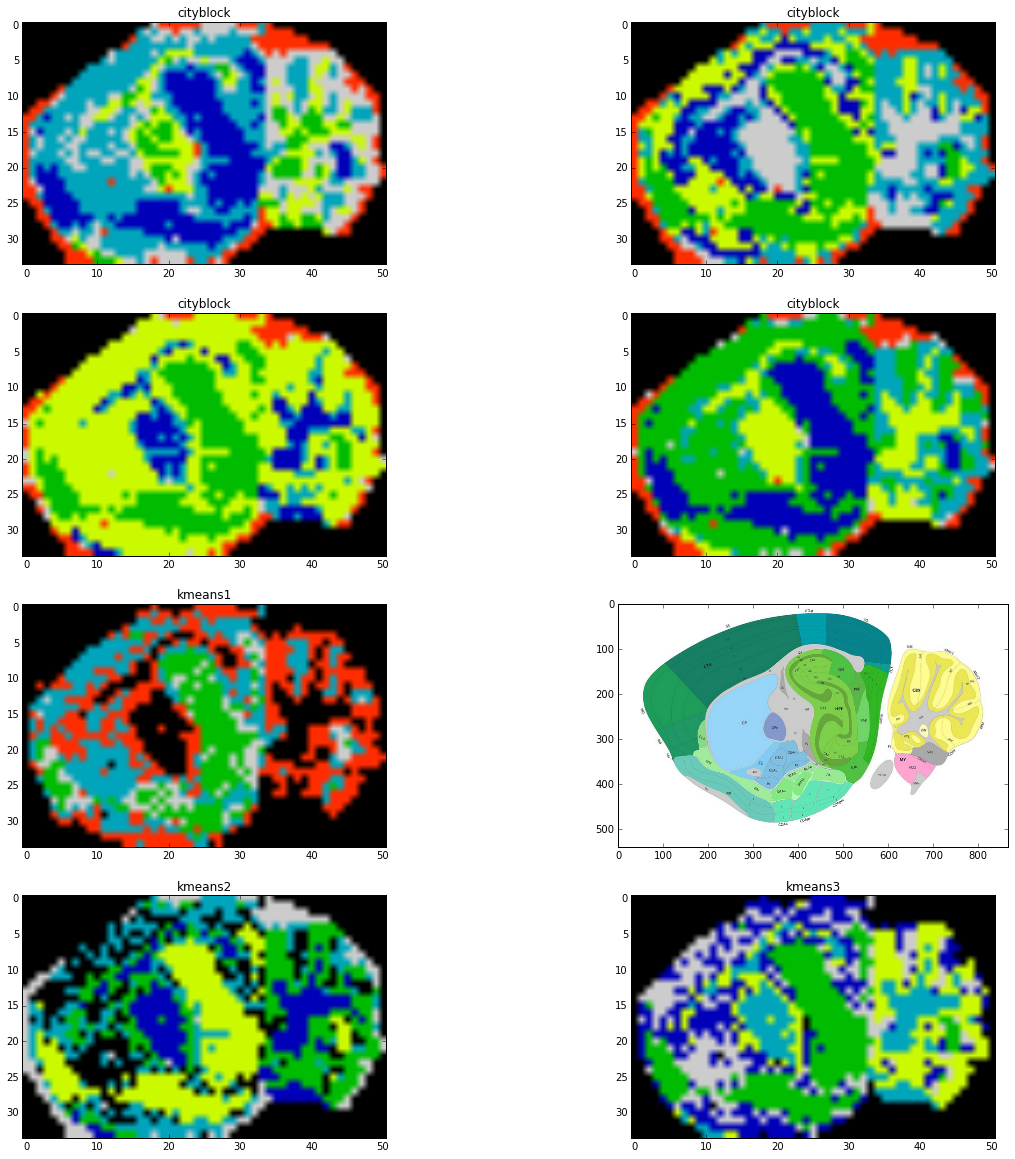

In [51]:
tempdata= data_na_AE4

aant_cluster=6

#verschillende distance metrics: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html
#Clustering
from scipy.spatial.distance import pdist

dist = pdist(tempdata, 'cityblock',p=2)
link= sch.linkage(dist,method='complete')
label = sch.fcluster(link, aant_cluster, 'maxclust')

dist2 = pdist(tempdata, 'cosine',p=2)
link2= sch.linkage(dist2,method='complete')
label2 = sch.fcluster(link2, aant_cluster, 'maxclust')

dist3 = pdist(tempdata, 'chebyshev',p=2)
link3= sch.linkage(dist3,method='complete')
label3 = sch.fcluster(link3, aant_cluster, 'maxclust')

dist4 = pdist(tempdata, 'sqeuclidean',p=2)
link4= sch.linkage(dist4,method='complete')
label4 = sch.fcluster(link4, aant_cluster, 'maxclust')



# plot dendrogram
#ct=link[-(aant_cluster-1),2]  
#P =sch.dendrogram(link,p=4, truncate_mode='level',no_labels='true',color_threshold=ct)
#plt.show()


#plot resultaat clustering

atlas=mpimg.imread('atlas.png')
img=get_label_img(label)
img2=get_label_img(label2)
img3=get_label_img(label3)
img4=get_label_img(label4)


fig2 = plt.figure(figsize = (20,20))
ax3 = fig2.add_subplot(421)
imgplot2=ax3.imshow(img, cmap='spectral')
ax3.set_title('cityblock')
ax4 = fig2.add_subplot(422)
imgplot2=ax4.imshow(img2, cmap='spectral')
ax4.set_title('cityblock')
ax5 = fig2.add_subplot(423)
imgplot3=ax5.imshow(img3, cmap='spectral')
ax5.set_title('cityblock')
ax6 = fig2.add_subplot(424)
imgplot1=ax6.imshow(img4, cmap='spectral')
ax6.set_title('cityblock')



aant_cluster=7

from scipy.cluster.vq import kmeans2, vq

centroids5, label5 = kmeans2(tempdata, aant_cluster,iter=10000)
centroids6, label6 = kmeans2(tempdata, aant_cluster)
centroids7, label7 = kmeans2(tempdata, aant_cluster)

#plot resultaat clustering

atlas=mpimg.imread('atlas.png')
img5=get_label_img(label5)
img6=get_label_img(label6)
img7=get_label_img(label7)

 
ax7 = fig2.add_subplot(425)
imgplot1=ax7.imshow(img5, cmap='spectral')
ax7.set_title('kmeans1')
atl=fig2.add_subplot(426)
atl.imshow(atlas)
ax8 = fig2.add_subplot(427)
imgplot1=ax8.imshow(img6, cmap='spectral')
ax8.set_title('kmeans2')
ax9 = fig2.add_subplot(428)
imgplot1=ax9.imshow(img7, cmap='spectral')
ax9.set_title('kmeans3')






#plt.colorbar(imgplot1,fraction=0.03)
#atl=fig2.add_subplot(222)
#atl.imshow(atlas)

#plt.savefig('SAE3_L4V2.pdf')




In [44]:
print get_ruis(label5)
print get_ruis(label6)
print get_ruis(label7)
    
    
    
    

0.460433673469
0.475535714286
0.458392857143


In [18]:
get_pca_vgl(label5)

(3.6133278600198384, array([[ 0.06,  0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.8 ],
        [ 0.  ,  0.24,  0.01,  0.6 ,  0.01,  0.02,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.52,  0.  ,  0.  ],
        [ 0.06,  0.03,  0.  ,  0.  ,  0.15,  0.44,  0.  ],
        [ 0.01,  0.  ,  0.83,  0.  ,  0.  ,  0.  ,  0.02],
        [ 0.44,  0.04,  0.02,  0.03,  0.  ,  0.19,  0.01],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.18,  0.03,  0.  ]]), array([ 0.  ,  0.44,  0.44,  0.52,  0.6 ,  0.8 ,  0.83]))

In [6]:
get_ruis(pca_label)

NameError: name 'pca_label' is not defined